[ok] Saved survival (20/50/80th) by bin → 3H_survival_from_direct_concentrations\survival_by_bin_percentiles.csv


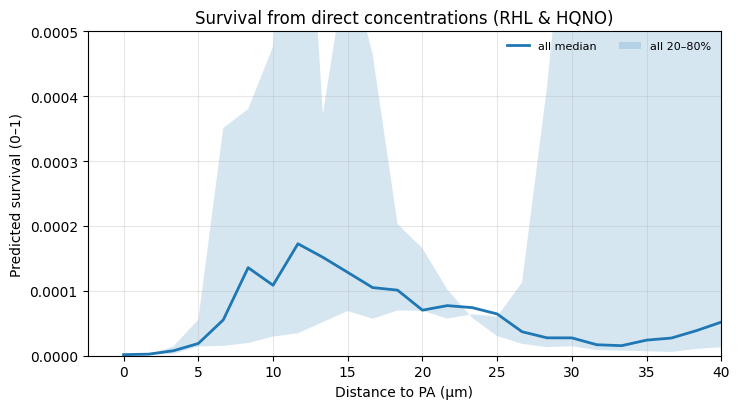

[ok] Plot saved → 3H_survival_from_direct_concentrations\survival_bands.png


: 

In [ ]:
# Survival from directly computed concentrations (percentile profiles)
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Config ----------------
# Inputs = the "bin_percentiles_all_subsets.csv" produced by your HQNO/RHL percentile notebooks
HQNO_PCT = Path(r"C:\Users\raachben\Documents\PhD\projets\Guilia\Paper\Analysis\Figures\Figures3\3C_hqno_concentration\hqno_bin_percentiles\bin_percentiles_all_subsets.csv")
RHL_PCT  = Path(r"C:\Users\raachben\Documents\PhD\projets\Guilia\Paper\Analysis\Figures\Figures3\3F_rhl_concentration\rhl_bin_percentiles\bin_percentiles_all_subsets.csv")

# Linear logit parameters (JSON with {"parameters":{"m_rhl":..., "m_hqno":..., "b":...}})
LINEAR_JSON = Path(r"C:\Users\raachben\Documents\PhD\projets\Guilia\Paper\Analysis\Figures\Figures3\3G_batch_survival\3G_Linear_RHL_HQNO_Logit_Model_params.json")

# Which subsets to use. Set to None to auto-use the intersection present in BOTH inputs.
SUBSETS_TO_USE = None  # e.g., ["all", "rep_2_3"]

# Outputs
OUT_DIR = Path("3H_survival_from_direct_concentrations")
OUT_DIR.mkdir(exist_ok=True, parents=True)
OUT_CSV = OUT_DIR / "survival_by_bin_percentiles.csv"
OUT_PNG = OUT_DIR / "survival_bands.png"  # small visualization

# ---------------- Helpers ----------------
def inv_logit(z):
    z = np.asarray(z, dtype=float)
    return 1.0 / (1.0 + np.exp(-z))

def _ensure_unique_per_bin(df, xcol="y_bin"):
    """
    Collapse to unique (subset, xcol) rows:
    - numeric columns -> median
    - non-numeric columns -> first
    """
    df = df.copy()

    # Coerce common numeric candidates
    for c in [xcol, "x_physical", "p20", "p50", "p80"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    group_cols = ["subset", xcol]

    # Identify numeric vs non-numeric AFTER coercion
    num_cols = set(df.select_dtypes(include=[np.number]).columns) - set(group_cols)

    agg = {}
    for c in df.columns:
        if c in group_cols:
            continue
        agg[c] = "median" if c in num_cols else "first"

    out = (
        df.groupby(group_cols, dropna=False, as_index=False)
          .agg(agg)
    )
    return out


# ---------------- Load percentiles & parameters ----------------
hqno = pd.read_csv(HQNO_PCT)
rhl  = pd.read_csv(RHL_PCT)

# Coerce numeric / clean columns we need
for d in (hqno, rhl):
    d["y_bin"] = pd.to_numeric(d["y_bin"], errors="coerce")
    if "x_physical" in d.columns:
        d["x_physical"] = pd.to_numeric(d["x_physical"], errors="coerce")
    for c in ["p20","p50","p80"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

# Optional: choose subset overlap
subs_hqno = set(hqno["subset"].unique())
subs_rhl  = set(rhl["subset"].unique())
subs_both = sorted(subs_hqno & subs_rhl)
if SUBSETS_TO_USE is None:
    subsets = subs_both
else:
    subsets = [s for s in SUBSETS_TO_USE if s in subs_both]
    if not subsets:
        raise ValueError(f"None of requested subsets in both inputs. Intersection={subs_both}")

# Keep only chosen subsets
hqno = hqno[hqno["subset"].isin(subsets)].copy()
rhl  = rhl[rhl["subset"].isin(subsets)].copy()

# Make sure rows are unique per (subset, y_bin); if not, collapse by median
hqno_u = _ensure_unique_per_bin(hqno, "y_bin")
rhl_u  = _ensure_unique_per_bin(rhl,  "y_bin")

# Rename percentile columns before merge
hqno_u = hqno_u.rename(columns={
    "p20":"hqno_p20", "p50":"hqno_p50", "p80":"hqno_p80",
    "x_physical":"x_phys_hqno", "replicates_used":"reps_hqno"
})
rhl_u = rhl_u.rename(columns={
    "p20":"rhl_p20", "p50":"rhl_p50", "p80":"rhl_p80",
    "x_physical":"x_phys_rhl", "replicates_used":"reps_rhl"
})

# Merge on subset + y_bin
df = pd.merge(rhl_u, hqno_u, on=["subset","y_bin"], how="inner", validate="one_to_one")

# Choose an x axis to carry forward: prefer RHL's physical if present else HQNO's, else y_bin
if "x_phys_rhl" in df.columns and df["x_phys_rhl"].notna().any():
    df["x_physical"] = df["x_phys_rhl"]
elif "x_phys_hqno" in df.columns and df["x_phys_hqno"].notna().any():
    df["x_physical"] = df["x_phys_hqno"]
else:
    df["x_physical"] = np.nan  # will fall back to y_bin for plotting

# Load linear params
with open(LINEAR_JSON, "r", encoding="utf-8") as f:
    cfg = json.load(f)
m_rhl  = float(cfg["parameters"]["m_rhl"])
m_hqno = float(cfg["parameters"]["m_hqno"])
b      = float(cfg["parameters"]["b"])

# ---------------- Survival per percentile track ----------------
for q in ("20","50","80"):
    # z_q = m_rhl * rhl_q + m_hqno * hqno_q + b
    rz = m_rhl  * df[f"rhl_p{q}"]  + m_hqno * df[f"hqno_p{q}"] /1000 + b ### factor 1000 for HQNO in uM
    df[f"z_p{q}"] = rz
    df[f"survival_p{q}"] = inv_logit(rz)

# Order columns & sort
cols_order = [
    "subset","y_bin","x_physical",
    "rhl_p20","rhl_p50","rhl_p80",
    "hqno_p20","hqno_p50","hqno_p80",
    "z_p20","z_p50","z_p80",
    "survival_p20","survival_p50","survival_p80",
]
# include replicate provenance if present
if "reps_rhl" in df.columns: cols_order.insert(3, "reps_rhl")
if "reps_hqno" in df.columns: cols_order.insert(4, "reps_hqno")

df_out = df[cols_order].sort_values(["subset","y_bin"]).reset_index(drop=True)
df_out.to_csv(OUT_CSV, index=False)
print(f"[ok] Saved survival (20/50/80th) by bin → {OUT_CSV}")

# ---------------- Quick visualization ----------------
plt.figure(figsize=(7.5, 4.2))
ax = plt.gca()

for subset, g in df_out.groupby("subset"):
    # choose x
    x = (pd.to_numeric(g["x_physical"], errors="coerce").to_numpy()
         if np.isfinite(pd.to_numeric(g["x_physical"], errors="coerce")).any()
         else pd.to_numeric(g["y_bin"], errors="coerce").to_numpy())
    s20 = pd.to_numeric(g["survival_p20"], errors="coerce").to_numpy()
    s50 = pd.to_numeric(g["survival_p50"], errors="coerce").to_numpy()
    s80 = pd.to_numeric(g["survival_p80"], errors="coerce").to_numpy()

    # sort by x for pretty plotting
    order = np.argsort(x)
    x, s20, s50, s80 = x[order], s20[order], s50[order], s80[order]

    ax.plot(x, s50, lw=2, label=f"{subset} median")
    ax.fill_between(x, s20, s80, alpha=0.18, label=f"{subset} 20–80%")

ax.set_xlabel("Distance to PA (µm)" if df_out["x_physical"].notna().any() else "Distance to PA (bins)")
ax.set_ylabel("Predicted survival (0–1)")
ax.set_title("Survival from direct concentrations (RHL & HQNO)")
ax.set_xlim(right=40)
ax.set_ylim(0.0, 0.0005)
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=8, frameon=False)
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
plt.show()
print(f"[ok] Plot saved → {OUT_PNG}")
